<a href="https://colab.research.google.com/github/DenisGubanov/Coursework-online-school-of-generations/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

# Class of working with a picture as with a canvas
# function: __init__(str,list), RGBDecImage()
class CanvasDetection:

	# Constructor overlaying Bounding Boxes on the image
	def __init__(self, path, boundingBoxs, predictBoxs=[], showImage=True):
		self.image = Image.open(path)
		fig, ax = plt.subplots()
		ax.imshow(self.image)
		for obj in boundingBoxs:
			rect = patches.Rectangle((obj.xyA[0], obj.xyA[1]), obj.xyB[0]-obj.xyA[0], obj.xyB[1]-obj.xyA[1], 
			                         linewidth=1, edgecolor='red', facecolor='none')
			ax.add_patch(rect)
			ax.text(min(obj.xyA[0],obj.xyB[0]), min(obj.xyA[1],obj.xyB[1]), obj.class_, bbox=dict(facecolor='red', alpha=1))
		for obj in predictBoxs:
			rect = patches.Rectangle((obj.xyA[0], obj.xyA[1]), obj.xyB[0]-obj.xyA[0], obj.xyB[1]-obj.xyA[1], 
			                         linewidth=1, edgecolor='blue', facecolor='none')
			ax.add_patch(rect)
			ax.text(max(obj.xyA[0],obj.xyB[0]), max(obj.xyA[1],obj.xyB[1]), obj.class_, color='white', bbox=dict(facecolor='blue', alpha=1))
		plt.axis('off') 
		if showImage: plt.show()
	
	# A function that allows you to get 3 RGB decomposition matrices
	def RGBDecImage(self, showImage=False):
		arr = np.array(self.image)
		RGB = [arr.copy(),arr.copy(),arr.copy()]
		RGB_matrix = np.zeros(shape=(3,len(arr),len(arr[0])))
		for i in range(len(arr)): 
			for j in range(len(arr[i])):
				for k in range(3):
					for t in range(3):
						if k != t: RGB[k][i][j][t] = 0 
						else: RGB_matrix[k][i][j] = RGB[k][i][j][t]
		if (showImage):
			fig, axs = plt.subplots(3, figsize=(12.1,12.1))
			for i in range(3):
				axs[i].imshow(RGB[i], interpolation='nearest')
			plt.show()
		return RGB_matrix


class BoundingBox:
	def __init__(self, coord, class_):
		self.xyA = [coord[0], coord[1]]
		self.xyB = [coord[2], coord[3]]
		self.class_ = class_;
	def square(self):
		return abs(self.xyA[0]-self.xyB[0])*abs(self.xyA[1]-self.xyB[1])
	def intersection(self, obj):
		l = max(self.xyA[0], obj.xyA[0])
		b = max(self.xyA[1], obj.xyA[1])
		r = min(self.xyB[0], obj.xyB[0])
		t = min(self.xyB[1], obj.xyB[1])
		return 0 if r-l <= 0 or t-b <= 0 else ((r-l) * (t-b))
	def union(self, obj):
		return (self.square()+obj.square())-self.intersection(obj)
	def sub(self, obj):
		return self.square()-self.intersection(obj)
	def iou(self, obj):
		return self.intersection(obj) / self.union(obj)
	def precision(self, obj):
		return self.intersection(obj) / obj.sub(self)
	def recall(self, obj):
		return self.intersection(obj) / self.square()		

class Model:
	class Conv:
		def __init__(self, filterShape=(1,3,3), strideShape=(1,1), featureMap=1, saveSize=True):
			self.filterShape = filterShape
			self.filter = np.zeros(shape=(featureMap, filterShape[1], filterShape[2]))
			self.strideShape = strideShape
			self.saveSize = saveSize
			self.shape_ = (1, 1, 1)
		def shape(self, size):
			sizenew = (size[0], int((size[1] - (2*(self.filterShape[1] - 2)*int(not(self.saveSize))) / self.strideShape[0])), 
			           int((size[2] - (2*(self.filterShape[2] - 2)*int(not(self.saveSize))) / self.strideShape[1])))
			self.shape_ = sizenew
			return sizenew
		def print(self):
			string = ' -- Conv -----'
			string += ' filter: ' + str(self.filterShape)
			string += ' stride: ' + str(self.strideShape)
			return string
	 
	class Polling:
		def __init__(self, filterShape=(2,2)):
			self.filterShape = filterShape
			self.filter = np.zeros(shape=(filterShape[0], filterShape[1]))
			self.shape_ = (1, 1, 1)
		def shape(self, size):
			sizenew = (size[0], int(size[1] / self.filterShape[0]),int(size[2] / self.filterShape[1]))
			self.shape_ = sizenew
			return sizenew
		def print(self):
			string = ' -- Polling --'
			string += ' filter: ' + str(self.filterShape)
			return string
	
	class FullConnection:
		def __init__(self, layerShape):
			self.layerShape = layerShape
		def print(self):
			print('test')
			
	
	def __init__(self, matrix):
		self.arch = []
		self.input = matrix
	def add(self, layer, count=1):
		for i in range(count): self.arch.append(layer)
	def shaping(self):
		shape = self.input.shape
		for l in self.arch:
			l.shape(shape)
			shape = l.shape(shape)
	 
	# Model dimension translation in FullConnection
	def convert(self):
		self.shaping()
		shape_ = self.arch[len(self.arch)-1].shape_
		shape_ = shape_[0]*shape_[1]*shape_[2]
		self.shape_fc = shape_
	
	# Output of the complete assembly of the model and its dimensions
	def print(self):
		n = 0
		shape = self.input.shape
		for l in self.arch:
			n += 1
			if (n == 1): 
				print('Input: '+str(self.input.shape))
			print(str(n)+l.print()+' -> '+str(l.shape(shape)))
			shape = l.shape(shape)
	 


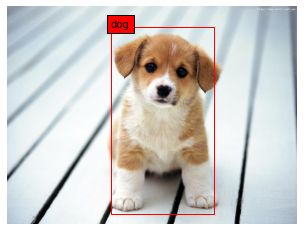

In [17]:
bb1 = BoundingBox([500, 100, 1000, 1000], 'dog')
cd1 = CanvasDetection('image.jpeg', [bb1])
rgb_layout = cd1.RGBDecImage()

In [65]:
model = Model(rgb_layout)
model.add(model.Conv())
model.add(model.Polling())
model.add(model.Conv())
model.add(model.Polling())
model.convert()
model.add(model.FullConnection(model.shape_fc))
model.print()

Input: (3, 1050, 1400)
1 -- Conv ----- filter: (1, 3, 3) stride: (1, 1) -> (3, 1050, 1400)
2 -- Polling -- filter: (2, 2) -> (3, 525, 700)
3 -- Conv ----- filter: (1, 3, 3) stride: (1, 1) -> (3, 525, 700)
4 -- Polling -- filter: (2, 2) -> (3, 262, 350)
test


TypeError: ignored

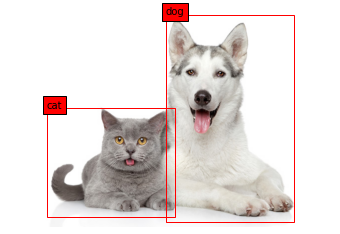

In [ ]:
bb1 = BoundingBox([320, 10, 580, 430], 'dog')
bb2 = BoundingBox([80, 200, 340, 420], 'cat')
cd1 = CanvasDetection('image2.jpg', [bb1,bb2])

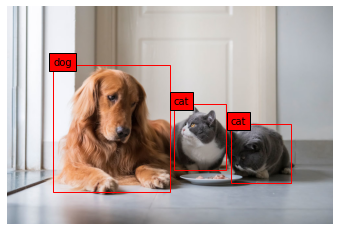

In [ ]:
b = [BoundingBox([140, 180, 500, 570], 'dog'),
     BoundingBox([510, 300, 670, 500], 'cat'),
     BoundingBox([685, 360, 870, 540], 'cat')]
cd1 = CanvasDetection('image3.jpg', b)

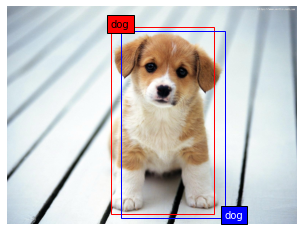

In [ ]:
bb1 = BoundingBox([500, 100, 1000, 1000], 'dog')
bb1_ = BoundingBox([550, 120, 1050, 1020], 'dog')
cd1 = CanvasDetection('image.jpeg', [bb1], [bb1_])